In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
import cv2
from scipy.stats import norm

# Read csv content

In [24]:
def read_dir_file_names(dirname, max=30):
    return [f"{dirname}/{x}" for x in os.listdir(dirname)][:max]


def read_log_file(path):
    return pd.read_csv(path, sep=";|:", names=["Sine number", "Amplitudes", "Frequencies", "Phases", "Decays"], engine='python')

In [25]:
def plot_distribution_hist(data, title, color, bins_count=6):
    counts, bins, _ = plt.hist(data, bins=bins_count, alpha=0.6, edgecolor='black', weights=np.ones_like(data), color=color, label=title)

    # Compute mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)

    # Generate x values for the bell-shaped curve
    from_point = mean - 4*std_dev
    to_point = mean + 4*std_dev
    x = np.linspace(from_point, to_point, 1000)

    # Compute the PDF (probability density function) of the normal distribution
    pdf = norm.pdf(x, mean, std_dev)

    # Scale the PDF to match the total count of the histogram
    scaling_factor = np.sum(counts) * (bins[1] - bins[0])
    pdf_scaled = pdf * scaling_factor

    # Plot the histogram with counts

    # Plot the bell-shaped curve 
    plt.fill_between(x, 0, pdf_scaled, where=(x >= from_point) & (x <= to_point), color='skyblue', alpha=0.5)

    plt.plot(x, pdf_scaled, 'r-', linewidth=2)
    plt.axvline(x=0, color='gray', linestyle='--')

    for count, x in zip(counts, bins):
        if count > 0:
            plt.text(x, count, str(int(count)), ha='left', va='bottom')

    # plt.xticks(
    #     np.concatenate(( positive_bins, -positive_bins )), 
    #     rotation=45
    # )

    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.legend()

    # Display the plot
    plt.grid(True)

# Test on standard distributed data

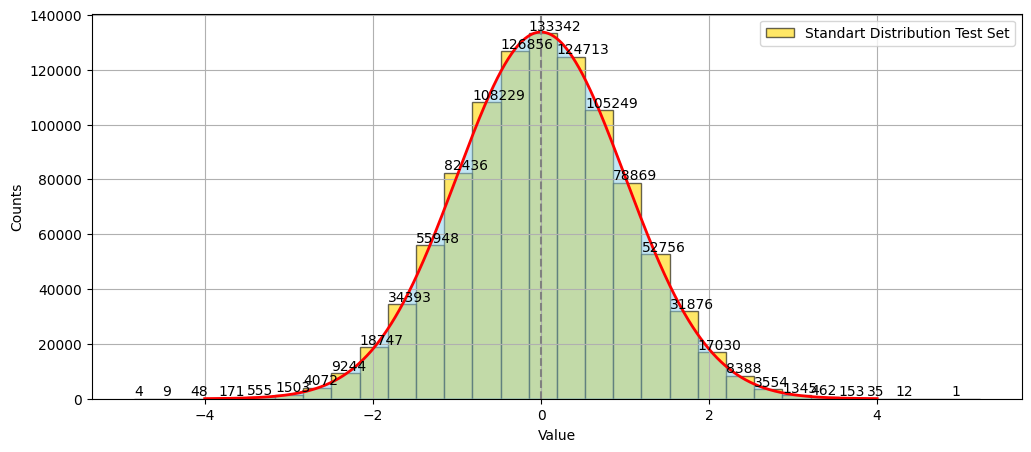

In [26]:
standard_distribution = np.random.normal(0, 1, 1000000)

plt.figure(figsize=(12, 5))
plot_distribution_hist(standard_distribution, "Standart Distribution Test Set", "gold", 30)


# Outlier remove strategies

In [27]:

def remove_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return data[z_scores < threshold]

# Using Interquartile Range
def remove_outliers_iqr(data):
    data = np.array(data)

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    cleaned_data = data[(data > lower_bound) & (data < upper_bound)]

    return cleaned_data, outliers


In [28]:
def extract__df_ilocs(paths):
    log_dfs = [read_log_file(x) for x in paths]

    return [df.iloc for df in log_dfs]

In [29]:
logs_count = 3000

GA_PATHS = read_dir_file_names("GA_OUTPUT_LOG", logs_count)
DE_PATHS = read_dir_file_names("DE_OUTPUT_LOG", logs_count)

In [30]:
read_log_file(GA_PATHS[0]).iloc[58, 4] # 58->62

'-0.0005923668563824'

In [31]:
de_df_ilocs = extract__df_ilocs(
    DE_PATHS, 
)

ga_df_ilocs = extract__df_ilocs(
    GA_PATHS, 
)

In [32]:
fitness_positions = (56,1)

# amplitudes_position = (58, 1) # 58->62 sine 1-5
# frequencies_position = (58, 2) # 58->62 sine 1-5
# phases_position = (58, 3) # 58->62 sine 1-5
# decays_position = (58, 4) # 58->62 sine 1-5

amplitudes_position = lambda i: (58 + i, 1) # 58->62 sine 1-5
frequencies_position = lambda i: (58 + i, 2) # 58->62 sine 1-5
phases_position = lambda i: (58 + i, 3) # 58->62 sine 1-5
decays_position = lambda i: (58 + i, 4) # 58->62 sine 1-5


de = {
    "Fitness": [float(iloc[fitness_positions]) for iloc in de_df_ilocs],
    "Sines": [
        {
            "Amplitudes": [float(iloc[amplitudes_position(i)]) for iloc in de_df_ilocs],
            "Frequencies": [float(iloc[frequencies_position(i)]) for iloc in de_df_ilocs],
            "Phases": [float(iloc[phases_position(i)]) for iloc in de_df_ilocs],
            "Decays": [float(iloc[decays_position(i)]) for iloc in de_df_ilocs],
        } for i in range(5)
    ]
}

ga = {
    "Fitness": [float(iloc[fitness_positions]) for iloc in ga_df_ilocs],
    "Sines": [
        {
            "Amplitudes": [float(iloc[amplitudes_position(i)]) for iloc in ga_df_ilocs],
            "Frequencies": [float(iloc[frequencies_position(i)]) for iloc in ga_df_ilocs],
            "Phases": [float(iloc[phases_position(i)]) for iloc in ga_df_ilocs],
            "Decays": [float(iloc[decays_position(i)]) for iloc in ga_df_ilocs],
        } for i in range(5)
    ]
}

# Found Sine waves demonstration

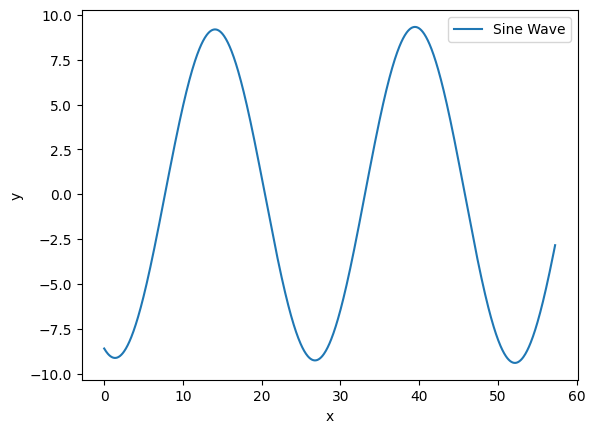

In [33]:
def plot_sine_wave(amplitude, frequency, phase, decay, title):
    x = np.linspace(0, amplitude * 2 * np.pi, 1000)
    y = amplitude * np.sin(frequency * x + phase) * np.exp(-decay * x)
    plt.plot(x, y, label=title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()


sine_index = 0
run_index = 0

plot_sine_wave(
    de["Sines"][sine_index]["Amplitudes"][run_index],
    de["Sines"][sine_index]["Frequencies"][run_index],
    de["Sines"][sine_index]["Phases"][run_index],
    de["Sines"][sine_index]["Decays"][run_index],
    "Sine Wave",
)

In [34]:
def calc_error(values):
    return np.array(values) - np.mean(values)

In [35]:
def calc_errors_without_outliers(values):
    cleaned_data, outliers = remove_outliers_iqr(values)
    
    return calc_error(cleaned_data), outliers

In [38]:
# PARAM_NAME = "Frequencies"
PARAM_NAME = "Fitness"

SINE_INDEX = 0
MAX_RUNS = 3000

de_data = de[PARAM_NAME][:MAX_RUNS]
ga_data = ga[PARAM_NAME][:MAX_RUNS]

# de_data = de["Sines"][SINE_INDEX][PARAM_NAME][:MAX_RUNS]
# ga_data = ga["Sines"][SINE_INDEX][PARAM_NAME][:MAX_RUNS]


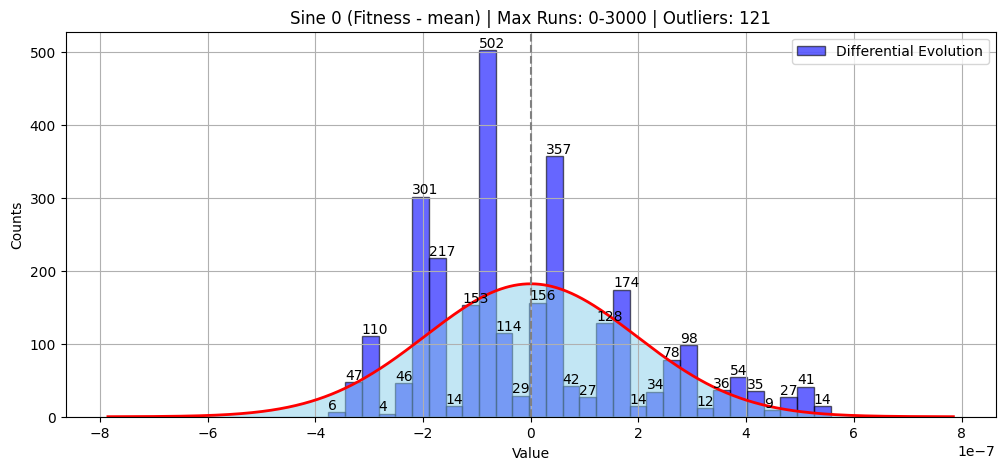

In [39]:
de_errors, de_outliers = calc_errors_without_outliers(de_data)

plt.figure(figsize=(12, 5))
plt.title(f'Sine {SINE_INDEX} ({PARAM_NAME} - mean) | Max Runs: 0-{MAX_RUNS} | Outliers: {len(de_outliers)}')

plot_distribution_hist(
    de_errors, 
    "Differential Evolution", 
    'blue', 
    30
)

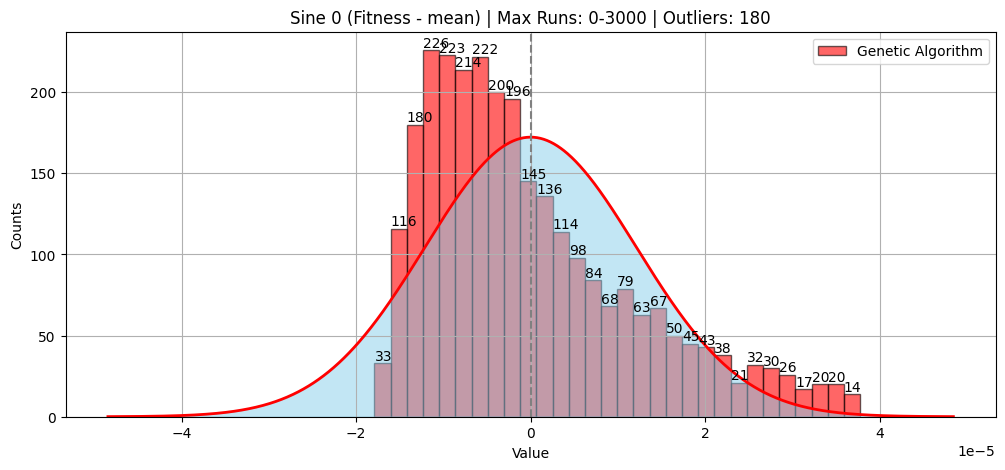

In [41]:
ga_errors, ga_outliers = calc_errors_without_outliers(ga_data)


plt.figure(figsize=(12, 5))
plt.title(f'Sine {SINE_INDEX} ({PARAM_NAME} - mean) | Max Runs: 0-{MAX_RUNS} | Outliers: {len(ga_outliers)}')

plot_distribution_hist(
    ga_errors, 
    "Genetic Algorithm", 
    'red', 
    30
)

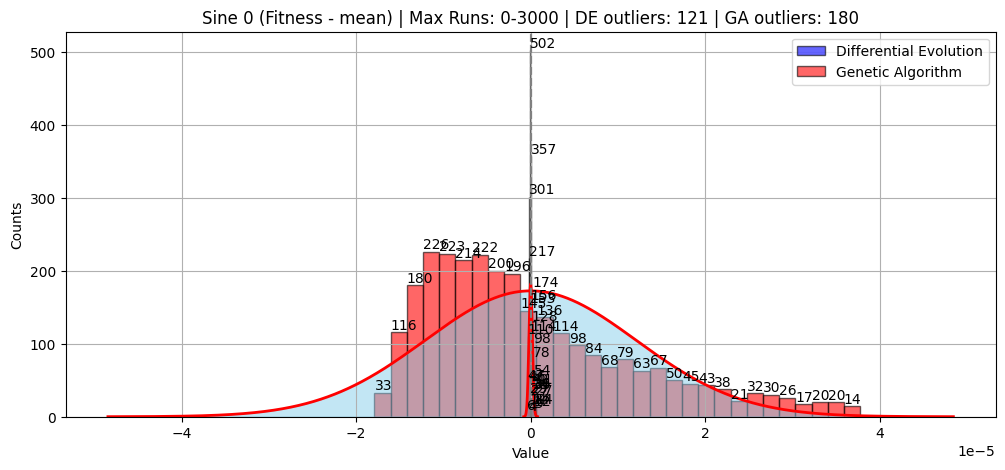

In [42]:
de_errors, de_outliers = calc_errors_without_outliers(de_data)
ga_errors, ga_outliers = calc_errors_without_outliers(ga_data)


plt.figure(figsize=(12, 5))

plt.title(f'Sine {SINE_INDEX} ({PARAM_NAME} - mean) | Max Runs: 0-{MAX_RUNS} | DE outliers: {len(de_outliers)} | GA outliers: {len(ga_outliers)}')

plot_distribution_hist(
    de_errors, 
    "Differential Evolution", 
    'blue', 
    30
)

plot_distribution_hist(
    ga_errors, 
    "Genetic Algorithm", 
    'red', 
    30
)

# Drawing all 4 sine params for selected sine

In [51]:
def sub_plot_all(sine_index, param_name, max_runs, bins_count=30):
    de_data = de["Sines"][sine_index][param_name][:max_runs]
    ga_data = ga["Sines"][sine_index][param_name][:max_runs]

    de_errors, de_outliers = calc_errors_without_outliers(de_data)
    ga_errors, ga_outliers = calc_errors_without_outliers(ga_data)

    plt.title(f'Errors ({param_name} - mean) | DE outliers: {len(de_outliers)} | GA outliers: {len(ga_outliers)}')
    plot_distribution_hist(ga_errors, "Genetic Algorithm", 'red', bins_count)
    plot_distribution_hist(de_errors, "Differential Evolution", 'blue', bins_count)


def plot_all_sine_params(sine_index, max_runs, bins_count=30):
    plt.figure(figsize=(14, 8))

    param_names = ["Amplitudes", "Frequencies", "Phases", "Decays"]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        sub_plot_all(sine_index, param_names[i], max_runs, bins_count)

        
    plt.suptitle(f'Sine {sine_index} | Max Runs: 0-{max_runs} ')

    plt.tight_layout()


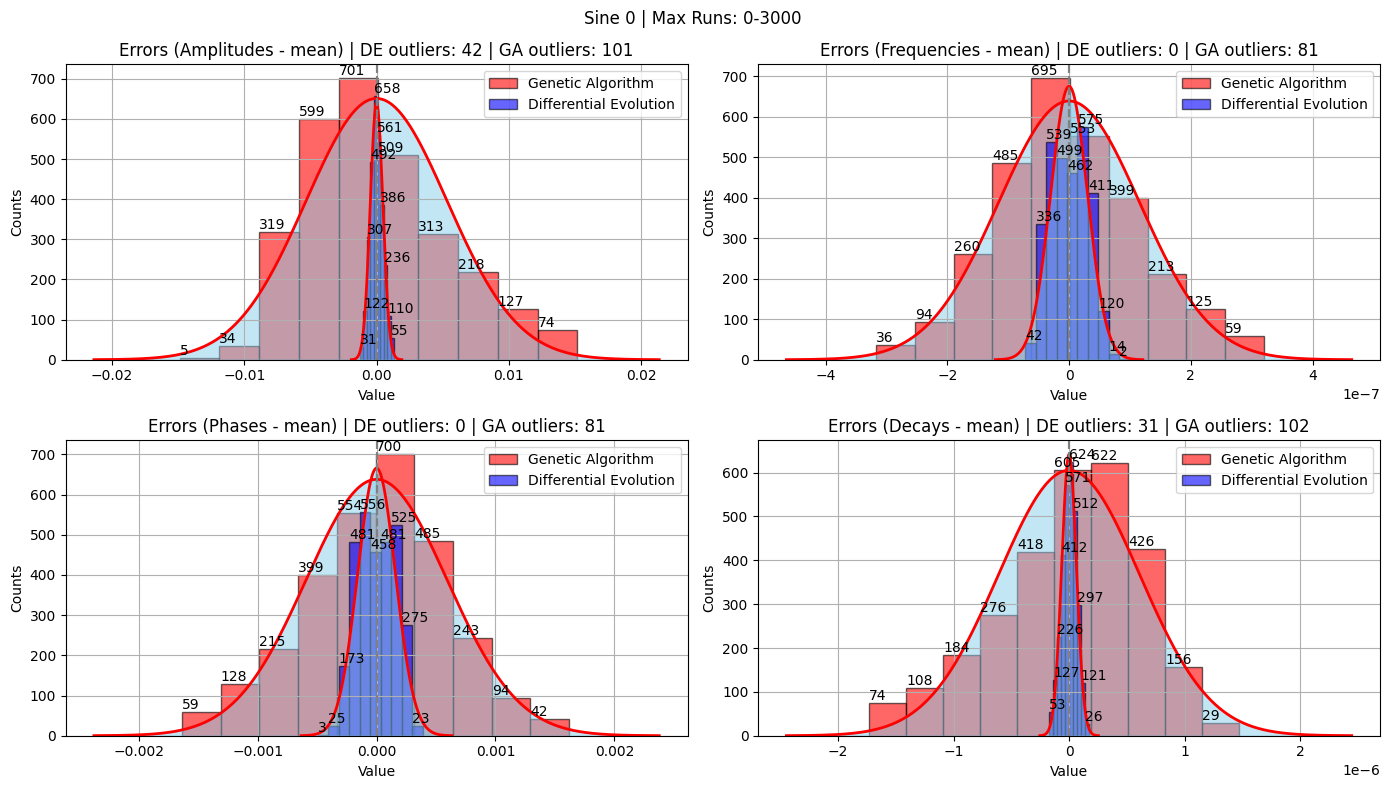

In [52]:
plot_all_sine_params(sine_index=0, max_runs=3000, bins_count=10)

In [56]:
OUT_FOLDER = 'results/save_imgs/GA_DE_ALL_PARAMS'

def make_images_from_plot():
    step = 10

    for i in range(2, 3000 + step, step):
        plot_all_sine_params(0, i, 10)

        print(i)
        plt.savefig(f'{OUT_FOLDER}/img_{i//step}.png')
        plt.close()

In [57]:
make_images_from_plot()

2
12
22
32
42
52
62
72
82
92
102
112
122
132
142
152
162
172
182
192
202
212
222
232
242
252
262
272
282
292
302
312
322
332
342
352
362
372
382
392
402
412
422
432
442
452
462
472
482
492
502
512
522
532
542
552
562
572
582
592
602
612
622
632
642
652
662
672
682
692
702
712
722
732
742
752
762
772
782
792
802
812
822
832
842
852
862
872
882
892
902
912
922
932
942
952
962
972
982
992
1002
1012
1022
1032
1042
1052
1062
1072
1082
1092
1102
1112
1122
1132
1142
1152
1162
1172
1182
1192
1202
1212
1222
1232
1242
1252
1262
1272
1282
1292
1302
1312
1322
1332
1342
1352
1362
1372
1382
1392
1402
1412
1422
1432
1442
1452
1462
1472
1482
1492
1502
1512
1522
1532
1542
1552
1562
1572
1582
1592
1602
1612
1622
1632
1642
1652
1662
1672
1682
1692
1702
1712
1722
1732
1742
1752
1762
1772
1782
1792
1802
1812
1822
1832
1842
1852
1862
1872
1882
1892
1902
1912
1922
1932
1942
1952
1962
1972
1982
1992
2002
2012
2022
2032
2042
2052
2062
2072
2082
2092
2102
2112
2122
2132
2142
2152
2162
2172
2182
2192
2202
2212
2

In [58]:
def create_video_from_images(image_folder, output_video, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort images numerically

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Specify the folder containing the images, the output video path, and frames per second (fps)
image_folder = OUT_FOLDER
output_video = "ga_de_all_params_hist_video.mp4"
fps = 30  # Frames per second

create_video_from_images(image_folder, output_video, fps)